In [2]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint


In [55]:
from gensim.models import word2vec

from sklearn.manifold import TSNE

In [35]:
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']


# uses custom metis style sheet for notebooks
from IPython.core.display import HTML
HTML("""<link rel="stylesheet" href="https://soph.info/metis/nb.css" type="text/css"/>""")
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle

Populating the interactive namespace from numpy and matplotlib


In [27]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline


In [3]:
import pandas as pd
from nltk.corpus import stopwords
from imblearn.under_sampling import RandomUnderSampler

Using TensorFlow backend.
/anaconda3/envs/Metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/Metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/Metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/Metis/lib/python3.7/site-packages/tensorflo

In [4]:
from sklearn.decomposition import NMF

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
import numpy as np

In [7]:
df = pd.read_csv('df_for_generation.csv')

In [50]:
df_sample = df[1:2000]

In [51]:
df_sample = df_sample.dropna()

In [52]:
df_sample.head()

,Unnamed: 0,content,date,publication,title,url
1,1,First lady Melania Trump has said little about...,2017/2/7,abcnews,Melania Trump Says White House Could Mean Mill...,http://abcnews.go.com/Politics/wireStory/melan...
2,2,A House committee voted on Tuesday to eliminat...,2017/2/7,abcnews,"As Trump Fears Fraud, GOP Eliminates Election ...",http://abcnews.go.com/Politics/wireStory/trump...
3,3,"This afternoon, three federal judges from the ...",2017/2/7,abcnews,Appeals Court to Decide on Challenge to Trump'...,http://abcnews.go.com/Politics/appeals-court-d...
4,4,At least four tornadoes touched down in Louisi...,2017/2/7,abcnews,At Least 4 Tornadoes Reported in Southeast Lou...,http://abcnews.go.com/US/23-states-winter-weat...
5,5,The mother of a backpacker slain in an Austral...,2017/2/7,abcnews,Mother of Backpacker Slain in Australia Critic...,http://abcnews.go.com/International/wireStory/...


In [17]:
df_sample['publication'].value_counts()

www        1134
europe      330
tass        285
abcnews     237
Name: publication, dtype: int64

In [18]:
df['publication'] = df['publication'].replace({'www':'CNN'})

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146394 entries, 0 to 146393
Data columns (total 6 columns):
Unnamed: 0     146394 non-null int64
content        146361 non-null object
date           143753 non-null object
publication    146394 non-null object
title          146392 non-null object
url            89383 non-null object
dtypes: int64(1), object(5)
memory usage: 6.7+ MB


In [72]:
df['content'] = df['content'].astype(str)

In [67]:
import nltk

In [74]:
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(df_sample):
    "drop nans, then apply 'clean_sentence' function to column content"
    data = df_sample.dropna(how="any")
    
    for col in ['content']:
        df_sample[col] = df_sample[col].apply(clean_sentence)
    
    return df

df_sample = clean_dataframe(df_sample)
df_sample.head(5)


,Unnamed: 0,content,date,publication,title,url
0,0,Michigan billionaire education activist Betsy ...,2017/2/7,abcnews,"Betsy DeVos Confirmed as Education Secretary, ...",http://abcnews.go.com/Politics/pence-break-tie...
1,1,First lady Melania Trump has said little about...,2017/2/7,abcnews,Melania Trump Says White House Could Mean Mill...,http://abcnews.go.com/Politics/wireStory/melan...
2,2,A House committee voted on Tuesday to eliminat...,2017/2/7,abcnews,"As Trump Fears Fraud, GOP Eliminates Election ...",http://abcnews.go.com/Politics/wireStory/trump...
3,3,"This afternoon, three federal judges from the ...",2017/2/7,abcnews,Appeals Court to Decide on Challenge to Trump'...,http://abcnews.go.com/Politics/appeals-court-d...
4,4,At least four tornadoes touched down in Louisi...,2017/2/7,abcnews,At Least 4 Tornadoes Reported in Southeast Lou...,http://abcnews.go.com/US/23-states-winter-weat...


In [75]:
def build_corpus(df_sample):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['content']:
        for sentence in df_sample[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(df_sample)        
corpus[0:2]

[['Michigan',
  'billionaire',
  'education',
  'activist',
  'Betsy',
  'DeVos',
  'was',
  'confirmed',
  'today',
  'to',
  'serve',
  'as',
  'the',
  'secretary',
  'of',
  'education',
  'in',
  'President',
  "Trump's",
  'administration,',
  'after',
  'Vice',
  'President',
  'Mike',
  'Pence',
  'cast',
  'a',
  'tie-breaking',
  'vote',
  'in',
  'the',
  'Senate.',
  'The',
  'Senate',
  'voted',
  'on',
  'DeVos"?highly',
  'contentious',
  'nomination',
  'this',
  'afternoon,',
  'and',
  'the',
  'tally',
  'was',
  'split',
  'evenly,',
  'requiring',
  'Pence',
  'to',
  'use',
  'his',
  'authority',
  'as',
  'president',
  'of',
  'the',
  'upper',
  'chamber',
  'of',
  'Congress',
  'to',
  'break',
  'the',
  'impasse.',
  'This',
  'was',
  'the',
  'first',
  'time',
  'that',
  'a',
  'vice',
  'president',
  'has',
  'broken',
  'a',
  'tie',
  'to',
  'confirm',
  'a',
  'Cabinet',
  'nominee.',
  'Pence',
  'read',
  'the',
  'vote',
  'count',
  '50-50',


In [ ]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/anaconda3/envs/Metis/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put i

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

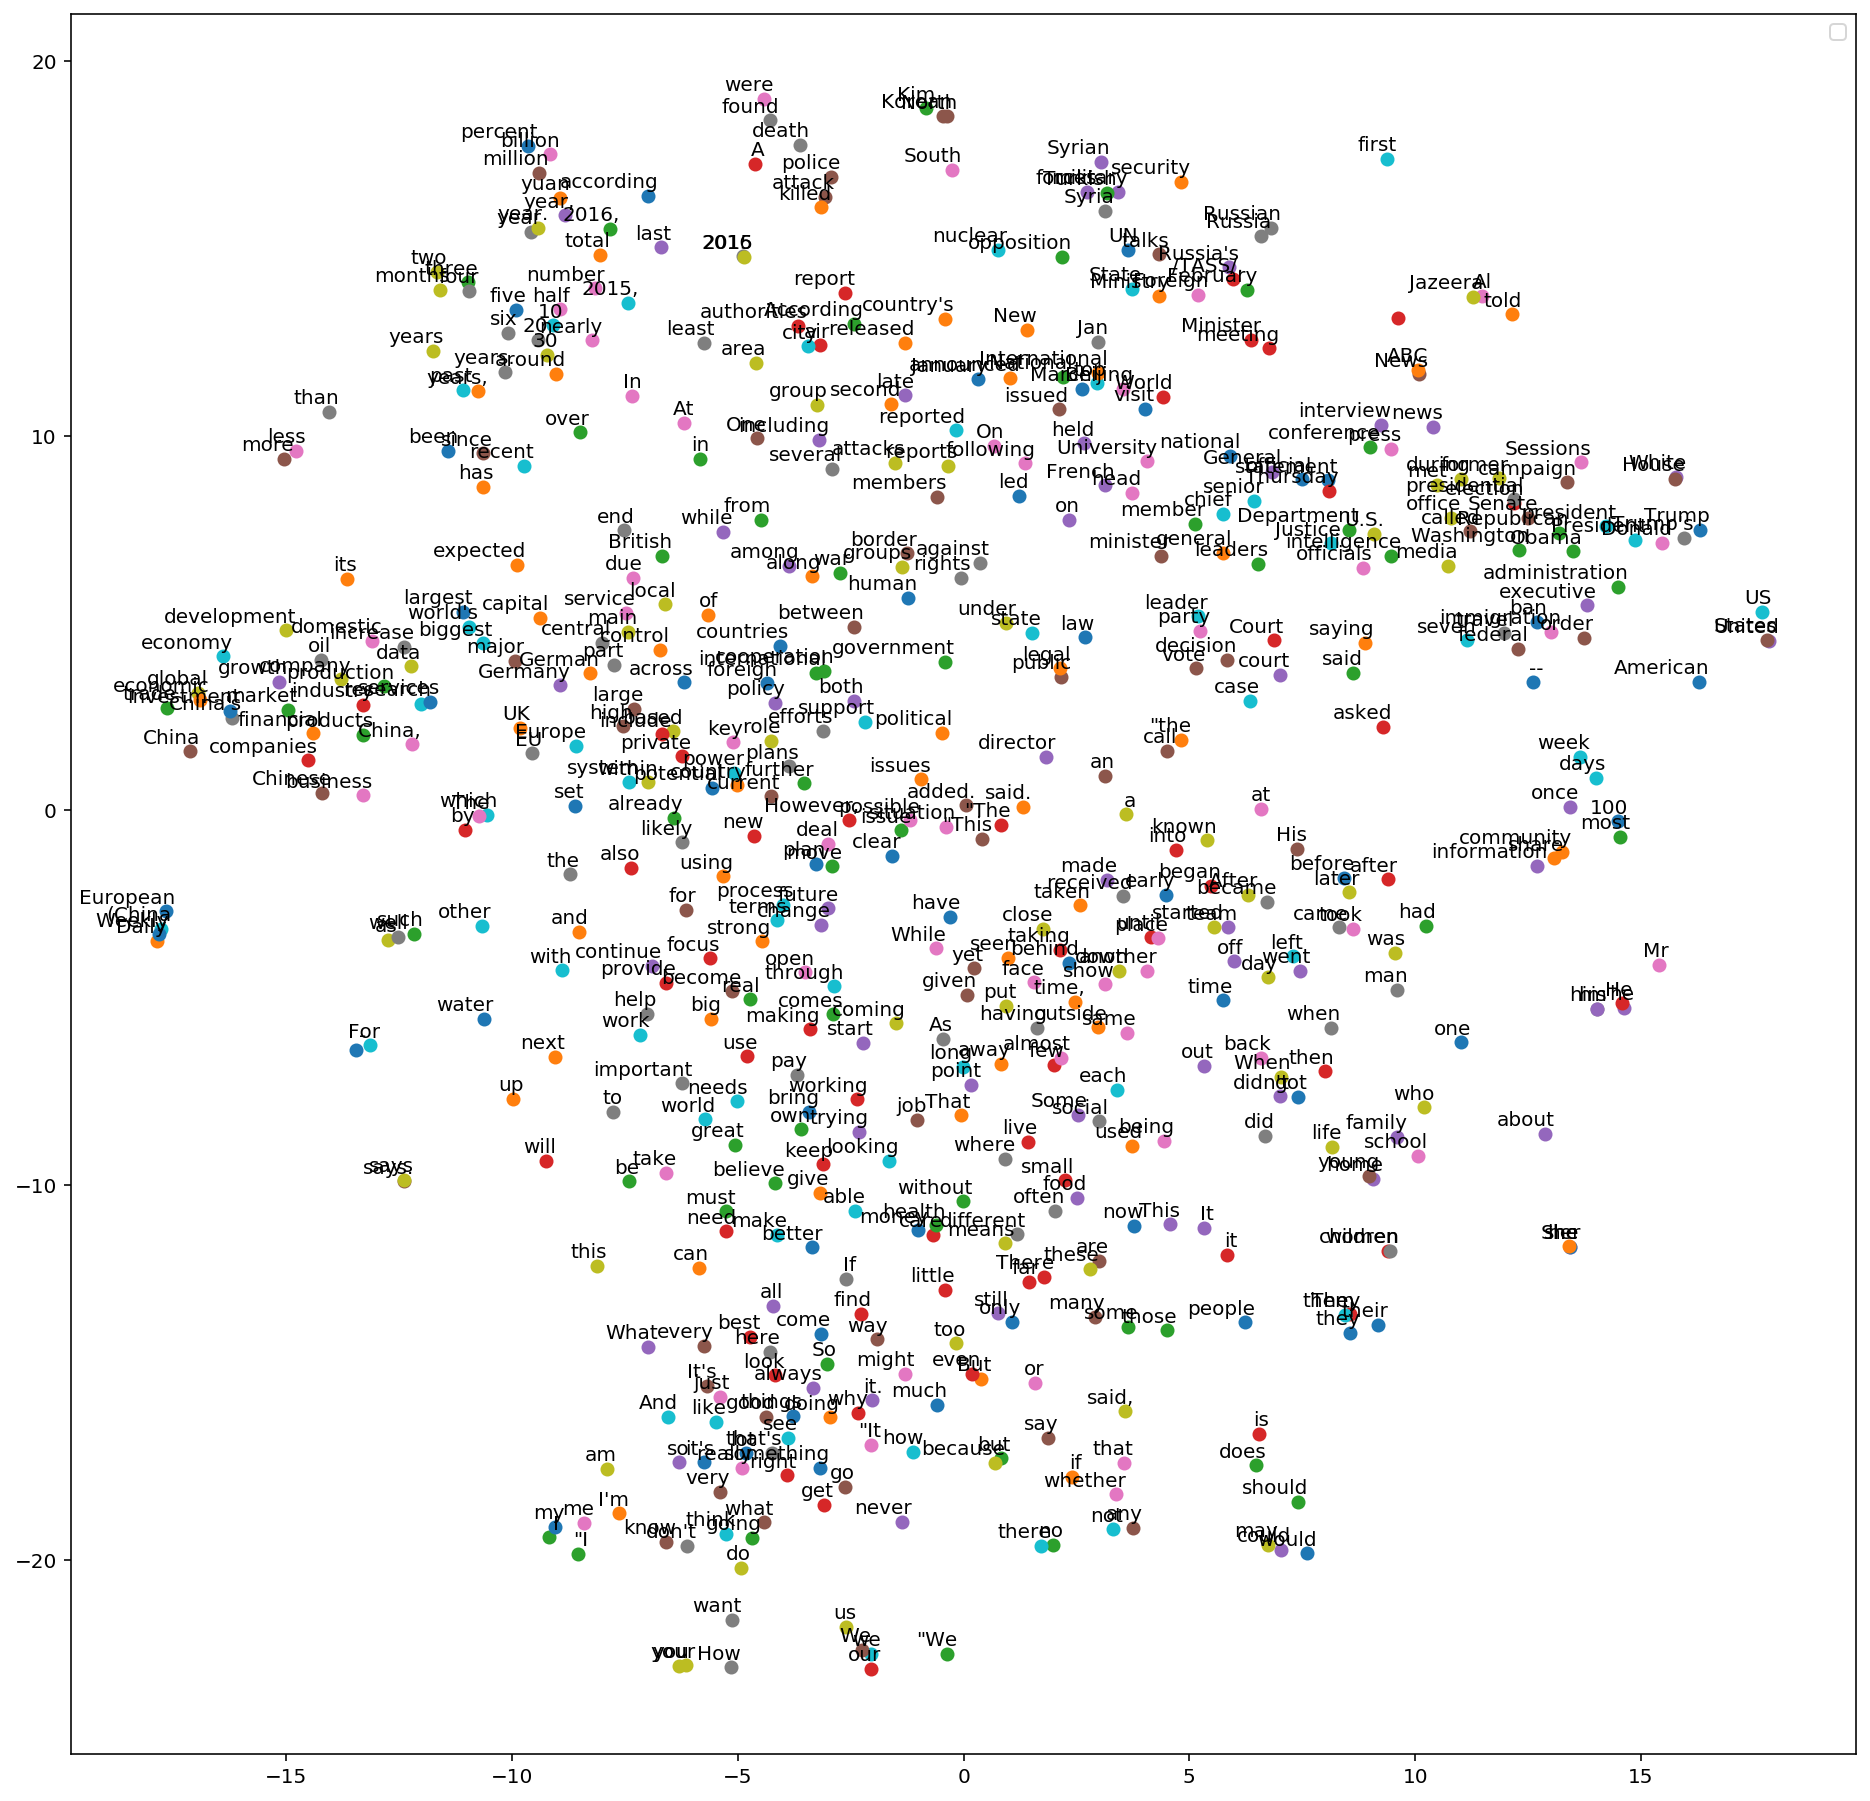

In [60]:
tsne_plot(model)


In [62]:
model.most_similar('Kim')

/anaconda3/envs/Metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Korean', 0.9014192819595337),
 ('death', 0.870883047580719),
 ('North', 0.8354127407073975),
 ('later', 0.7816292643547058),
 ('police', 0.7634390592575073),
 ('began', 0.7397421002388),
 ('man', 0.7363357543945312),
 ('leader', 0.7075875401496887),
 ('court', 0.6993695497512817),
 ('authorities', 0.6655164957046509)]

In [63]:
model.most_similar('president')

/anaconda3/envs/Metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Trump', 0.9182848334312439),
 ('Republican', 0.8981107473373413),
 ('President', 0.8721624612808228),
 ('Donald', 0.8691886067390442),
 ("Trump's", 0.8627253770828247),
 ('Obama', 0.861690104007721),
 ('Washington', 0.8292200565338135),
 ('campaign', 0.8147748708724976),
 ('Sessions', 0.8057355880737305),
 ('House', 0.8052879571914673)]

In [65]:
model.most_similar('border')

/anaconda3/envs/Metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('rights', 0.8392494320869446),
 ('groups', 0.8142220377922058),
 ('against', 0.763477623462677),
 ('along', 0.7591850757598877),
 ('security', 0.7576882839202881),
 ('forces', 0.7545511722564697),
 ('war', 0.7491942048072815),
 ('military', 0.7260808944702148),
 ('countries', 0.7240318059921265),
 ('Syria', 0.7187029123306274)]